## HDDM Analysis of Pizzagalli et al 2008

In [1095]:
import datetime, mmap,os,re, sys, decimal, hddm
import numpy as np 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy as sp
from patsy import dmatrix
% matplotlib inline 
% load_ext rpy2.ipython
%R library(lsmeans)
%R library(afex)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['afex', 'reshape2', 'lme4', 'Matrix', 'lsmeans', 'estimability',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='<U12')

## Getting the data together  
Most of this was taken from the PRT_Prettier notebook, with a few adjustments.  
TO DO: Consider replacing '/' with another character for less headache later

In [1096]:
uname = !whoami
uname = uname[0]
path2analysis = '/Users/' + uname + '/Work/Expts/SIGDEP/Data/Analysis/' # also where git repo lives
path2data = '/Users/' + uname + '/Work/Expts/SIGDEP/Data/PostApril04_Data/TIME_1/'
today = datetime.datetime.today().strftime("%m_%d_%Y")

In [1097]:
def SigDetParse(fname):
    '''Open the file, use regex to pull out key vars, output a clean df.'''
    
    df = []
    d = {}
    ct = 0
    
    # Begin reading in data from the line including 'reward_due', as that's unlikely to occur anywhere earlier
    with open(fname) as f:
        for line in f:
            if 'reward_due' in line:
                for line in f:
                    d[ct] = {'trial':line.split('\t')[0],
                             'length':line.split('\t')[1],
                             'time':line.split('\t')[2], # tempting to change to RT but keep same for backwards compat
                             'key_press':line.split('\t')[3],
                             'correct':line.split('\t')[4],
                             'did_reward':line.split('\t')[5],
                             'reward_due':line.split('\t')[6],
                             'short_due':line.split('\t')[7],
                             'long_due':line.split('\t')[8],
                             'outlier':line.split('\t')[9].strip('\n')}
                    ct = ct + 1
    df = pd.DataFrame.from_dict(d,orient='index')
    

    for val in [('subject','Subject ID:'), ('date','Date:'), ('bias','Bias:'), ('short_key','Key for short mouth:'), ('long_key','Key for long mouth:'),
               ('response_bias', 'RB_adjst_all:'), ('discriminability','dis_adjst_all:')]:
        
        var_name, pattern = val
        if var_name != 'long_key' and var_name != 'short_key':
            df[var_name] = np.nan
        elif var_name == 'long_key' or var_name == 'short_key':
            df[var_name] = 'z'
        # Need some default values b/c some subjects have missing data        

        if var_name == 'date':
            var_def = re.compile(pattern + '[\s]+([\d]+/[\d]+/[\d]+)')
        elif var_name == 'short_key' or var_name == 'long_key':
            var_def = re.compile(pattern + '[\s]+(/)')
        elif var_name == 'response_bias' or var_name == 'discriminability':
            var_def = re.compile(pattern + '[\s]+([\d]+.[\d][\d][\d][\d])')
            var_def_neg = re.compile(pattern + '[\s]+(-[\d]+.[\d][\d][\d][\d])')
        else:
            var_def = re.compile(pattern + '[\s]+([\w]+)')
        
        if var_name != 'response_bias' and var_name != 'discriminability':
            with open(fname) as f:
                for line in f:
                    var_match = var_def.search(line)
                    if var_match:
                        result = var_match.group(1)
                        df[var_name] = result
        else: # it gets a little tricky here because discriminability and response bias appear multiple times throughout 
            done = 'false' # the file. For now, we just want the first tim (the "overall"). It also gets hairy bc response 
            with open(fname) as f: # bias can be negative
                    for line in f:
                        if done == 'false':
                            var_match = var_def.search(line)
                            var_match_neg = var_def_neg.search(line)
                            if var_match:
                                result = var_match.group(1)
                                df[var_name] = result
                                done = 'true'
                            elif var_match_neg:
                                result = var_match_neg.group(1)
                                df[var_name] = result
                                done = 'true'
    return df

In [1098]:
raw_files = path2data + 'done/SigDet' + '*.txt.out'
raw_files = !ls {raw_files}
dfs = []
for file in raw_files:
    statinfo = os.stat(file) # checking for empty files
    if statinfo.st_size == 0:
        print ('Empty file: '+ file)
    else:
        df = SigDetParse(file)
        dfs.append(df)
out = pd.DataFrame
out = pd.concat(dfs)
out = out[['subject','date','bias','short_key', 'long_key','trial','length','time','key_press','correct','did_reward','reward_due','short_due','long_due','outlier',
          'discriminability', 'response_bias']]
out.subject = out.subject.astype(str).apply(lambda x: x.zfill(3))

**Note:** The response bias and discriminability columns are overall scores (from trials 0-299)

In [1099]:
out.head()

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,did_reward,reward_due,short_due,long_due,outlier,discriminability,response_bias
0,032,5/11/2004,short,z,/,1,short,546,/,0,0,0,0,0,0,0.8603,-0.1070
1,032,5/11/2004,short,z,/,2,long,738,/,1,1,1,0,0,0,0.8603,-0.1070
2,032,5/11/2004,short,z,/,3,short,815,z,1,1,1,0,0,0,0.8603,-0.1070
3,032,5/11/2004,short,z,/,4,long,625,/,1,0,0,0,0,0,0.8603,-0.1070
4,032,5/11/2004,short,z,/,5,short,1267,z,1,0,0,0,0,0,0.8603,-0.1070


In [1100]:
out.subject.nunique()

90

In [1101]:
out.subject.unique()

array(['032', '033', '034', '035', '036', '037', '038', '039', '040',
       '041', '042', '043', '044', '045', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084', '085', '086', '087', '088', '089', '090',
       '091', '092', '093', '094', '095', '096', '097', '098', '099',
       '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '046', '047', '048', '049', '050',
       '051', '052', '053', '054', '055', '056', '057', '058', '059'], dtype=object)

In [1102]:
groups = pd.read_csv(path2data + 'sigdep_groups.csv')
groups = groups[['Subject','exclude', 'group', 'age', 'sex', 'BDItotal', 'Pure_Anhed', 'RB_adjst_all1_1', 
                 'RB_adjst_all1_2', 'RB_adjst_all1_3', 'dis_adjst_all1_1', 'dis_adjst_all1_2', 'dis_adjst_all1_3', 
                'avT1_4', 'avT1_1', 'avrhT1_1', 'avlnT1_1', 'avshT1_1', 'avlgT1_1', 'avT1_2', 'avrhT1_2', 'avlnT1_2',
                'avshT1_2', 'avlgT1_2', 'avT1_3', 'avrhT1_3', 'avlnT1_3', 'avshT1_3', 'avlgT1_3',  
                'avrhT1_4', 'avlnT1_4', 'avshT1_4', 'avlgT1_4']] 
groups = groups.rename(index = str, columns={'Subject': 'subject'})
groups.subject = groups.subject.astype(str).apply(lambda x: x.zfill(3))
groups.head()

,subject,exclude,group,age,sex,BDItotal,Pure_Anhed,RB_adjst_all1_1,RB_adjst_all1_2,RB_adjst_all1_3,...,avlgT1_2,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
0,039,0.0,MDD,53,f,40,11,0.257556,0.259358,0.061919,...,829.23999,651.353516,573.020386,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002
1,040,1.0,MDD,29,f,20,5,0.222434,0.258315,0.214273,...,537.36585,458.216858,465.333344,450.926819,465.333344,450.926819,507.884613,495.29135,507.884613,495.29135
2,041,0.0,MDD,43,m,28,4,0.072285,-0.063303,-0.043575,...,542.59998,470.151520,479.040009,461.081635,461.081635,479.040009,505.691284,537.52026,537.520264,505.69128
3,046,0.0,MDD,42,m,27,10,0.189317,0.435575,0.243272,...,355.79999,329.297882,279.088898,375.408173,375.408173,279.088898,343.820679,427.25851,427.258514,343.82068
4,047,0.0,MDD,44,f,44,7,0.150296,0.188995,0.234880,...,686.41998,841.397949,831.708313,850.700012,831.708313,850.700012,697.289673,764.16895,697.289673,764.16895


In [1103]:
groups.subject.unique()

array(['039', '040', '041', '046', '047', '049', '050', '051', '052',
       '053', '054', '055', '056', '057', '058', '059', '060', '061',
       '062', '063', '064', '065', '066', '067', '068', '069', '070',
       '071', '072', '073', '074', '075', '076', '077', '078', '079',
       '080', '081', '082', '083', '084', '085', '086', '087', '088',
       '089', '090', '091', '092', '093', '094', '095', '096', '097',
       '098', '099', '100', '101', '102', '103', '104', '105', '106',
       '107', '108', '109', '110', '111', '112', '113', '114', '115',
       '116', '117', '118', '119', '120', '121'], dtype=object)

In [1104]:
data = out.merge(groups, how='outer')
data = data[pd.notnull(data['group'])] # the groups file doesn't have 32-38 (prob pilots)
data = data[data.group != 'BIPOLAR'] # only care about MDD vs CTL (for now!)
data = data[data.exclude != 1] # get rid of three people that Diego excluded for > 40 outlier trials
#data = data[data.outlier != 1] # get rid of the outlier trials
data.head() 

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,...,avlgT1_2,avT1_3,avrhT1_3,avlnT1_3,avshT1_3,avlgT1_3,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4
2100,039,6/15/2004,short,/,z,1,short,499,/,1,...,829.23999,651.353516,573.020386,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002
2101,039,6/15/2004,short,/,z,2,long,628,z,1,...,829.23999,651.353516,573.020386,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002
2102,039,6/15/2004,short,/,z,3,short,705,/,1,...,829.23999,651.353516,573.020386,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002
2103,039,6/15/2004,short,/,z,4,long,588,z,1,...,829.23999,651.353516,573.020386,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002
2104,039,6/15/2004,short,/,z,5,short,667,z,0,...,829.23999,651.353516,573.020386,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002


In [1105]:
data.subject.nunique() # getting closer, we have two more than they do. 

50

In [1106]:
data.groupby('group').subject.nunique() # looks like 2 more controls were excluded

group
CON    27
MDD    23
Name: subject, dtype: int64

I found another file that has a list of all participants and who was included, looks like two more controls were excluded (063 & 069), which fits nicely!

In [1107]:
final_include = pd.read_csv(path2data + 'IncludedFinalAnalyses_20july07.csv')
final_include = final_include.rename(index = str, columns = {'subID': 'subject'})
final_include.subject = final_include.subject.astype(str).apply(lambda x: x.zfill(3))
data = data.merge(final_include, on = 'subject', how = 'outer')
data = data[pd.notnull(data['group'])] # do this again
data = data[data.excluded == 0]
data = data[data.outlier == '0']

In [1108]:
data

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,...,avlnT1_3,avshT1_3,avlgT1_3,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4,excluded,Group#,Group
0,039,6/15/2004,short,/,z,1,short,499,/,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
1,039,6/15/2004,short,/,z,2,long,628,z,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
2,039,6/15/2004,short,/,z,3,short,705,/,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
3,039,6/15/2004,short,/,z,4,long,588,z,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
4,039,6/15/2004,short,/,z,5,short,667,z,0,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
5,039,6/15/2004,short,/,z,6,short,587,/,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
6,039,6/15/2004,short,/,z,7,short,1373,z,0,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
7,039,6/15/2004,short,/,z,8,long,823,z,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
8,039,6/15/2004,short,/,z,9,short,1120,z,0,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD
9,039,6/15/2004,short,/,z,10,short,583,/,1,...,728.119995,573.020386,728.119995,653.275146,734.02002,653.275146,734.02002,0,0,MDD


In [1109]:
data.groupby('group').subject.nunique() # Wohoo, looks like we're there!

group
CON    25
MDD    23
Name: subject, dtype: int64

In [1110]:
data.subject.unique()

array(['039', '041', '061', '062', '064', '065', '066', '067', '068',
       '069', '070', '071', '072', '073', '074', '075', '076', '077',
       '078', '079', '092', '094', '097', '098', '100', '104', '106',
       '108', '109', '111', '112', '113', '114', '115', '116', '118',
       '046', '047', '049', '050', '051', '052', '054', '055', '056',
       '057', '058', '059'], dtype=object)

In [1111]:
data.response_bias = pd.to_numeric(data.response_bias)
data.discriminability = pd.to_numeric(data.discriminability)

In [1112]:
# add block info
data['trial'] = pd.to_numeric(data['trial'])
data.loc[data['trial'] <= 100, 'block'] = 1
data.loc[(data['trial'] > 100) & (data['trial'] <= 200), 'block'] = 2
data.loc[data['trial'] > 200, 'block'] = 3

In [1113]:
#checking that that looks okay
data.groupby('block').count()

,subject,date,bias,short_key,long_key,trial,length,time,key_press,correct,...,avlnT1_3,avshT1_3,avlgT1_3,avrhT1_4,avlnT1_4,avshT1_4,avlgT1_4,excluded,Group#,Group
block,,,,,,,,,,,,,,,,,,,,,
1.0,4700,4700,4700,4700,4700,4700,4700,4700,4700,4700,...,4700,4700,4700,4700,4700,4700,4700,4700,4700,4700
2.0,4739,4739,4739,4739,4739,4739,4739,4739,4739,4739,...,4739,4739,4739,4739,4739,4739,4739,4739,4739,4739
3.0,4720,4720,4720,4720,4720,4720,4720,4720,4720,4720,...,4720,4720,4720,4720,4720,4720,4720,4720,4720,4720


In [1114]:
data['block_RB'] = np.nan
data['block_disc'] = np.nan
data.loc[data['block'] == 1, 'block_RB'] = data['RB_adjst_all1_1']
data.loc[data['block'] == 2, 'block_RB'] = data['RB_adjst_all1_2']
data.loc[data['block'] == 3, 'block_RB'] = data['RB_adjst_all1_3'] #adding the appropropriate RBs for each block
data.loc[data['block'] == 1, 'block_disc'] = data['dis_adjst_all1_1']
data.loc[data['block'] == 2, 'block_disc'] = data['dis_adjst_all1_2']
data.loc[data['block'] == 3, 'block_disc'] = data['dis_adjst_all1_3']

In [1115]:
# adding rich and lean column
data['rich_lean'] = np.nan
data.loc[data['length'] == data['bias'], 'rich_lean'] = 'rich'
data.loc[data['length'] != data['bias'], 'rich_lean'] = 'lean'

## Rerunning the analyses in the paper to make sure everything looks the same as Diego's.

### Respnse Bias

"As shown in Fig. 2A, relative to control subjects, MDD subjects showed significantly lower overall response bias scores: (Group: F = 5.89, df = 1,46, p < 0.020, partial eta2 = 0.11). The main effect of Block and the Group x Block interaction were not significant, both Fs < 0.72, df = 2,92, both ps > 0.50. The main effect of Group was confirmed also when entering age as a covariate(F = 6.43, df = 1,45, p < 0.015, partial eta2 = 0.13)." Pizzagalli et. al. 2008

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: block_RB
       Effect    df  MSE      F p.value
1       group 1, 46 0.09 5.89 *     .02
2       block 2, 92 0.02   0.71     .49
3 group:block 2, 92 0.02   0.09     .92


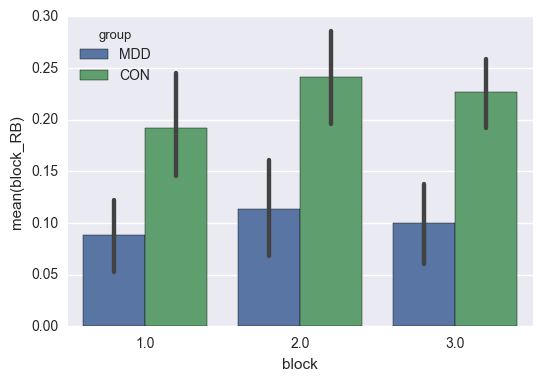

In [1116]:
reward_learning_block_plot = sns.barplot(y='block_RB', x = 'block', hue = 'group', data = data, ci = 68, units = 'subject')
%Rpush data
%R resp_bias_block_anova <- aov_ez("subject", dv = "block_RB", data = data,between="group",within = "block", anova_table=list(correction="none", es = "none"))
%R print (resp_bias_block_anova)

The above is pretty much identical to the paper (especially the graph!)

In [1117]:
%Rpush data
%R resp_bias_ancova <- aov_ez("subject", dv = "response_bias", type = 2, data = data,between="group", covariate = 'age', factorize = FALSE, anova_table=list(correction="none", es = "none"))
%R print (resp_bias_ancova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 2 tests)

Response: response_bias
  Effect    df  MSE      F p.value
1  group 1, 45 0.03 6.44 *     .01
2    age 1, 45 0.03   0.41     .53


The above is also almost identical to the paper.

### Discriminability

"No significant effects emerged, all Fs < 0.54, all
ps > 0.50. Accordingly, controls and MDD subjects found
the task equally difficult." Pizzagalli et. al. 2008

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: block_disc
       Effect    df  MSE    F p.value
1       group 1, 46 0.22 0.38     .54
2       block 2, 92 0.03 0.54     .58
3 group:block 2, 92 0.03 0.35     .70


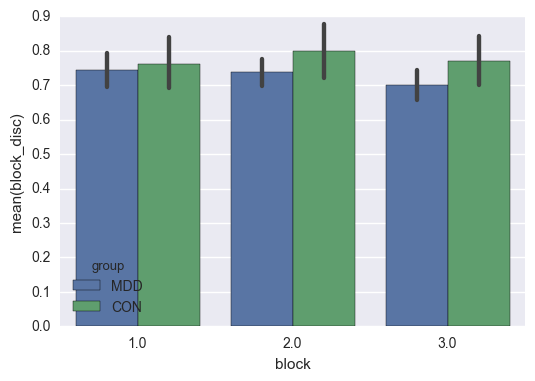

In [1118]:
disc_block_plot = sns.barplot(y='block_disc', x = 'block', hue = 'group', data = data, ci = 68, units = 'subject')
%Rpush data
%R disc_block_anova <- aov_ez("subject", dv = "block_disc", data = data,between="group",within = "block", anova_table=list(correction="none", es = "none"))
%R print (disc_block_anova)

You can kind of see the trend that we found with the embarc data

In [1119]:
%Rpush data
%R disc_ancova <- aov_ez("subject", dv = "discriminability", type = 2, data = data,between="group", covariate = 'age', factorize = FALSE, anova_table=list(correction="none", es = "none"))
%R print (disc_ancova)

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 2 tests)

Response: discriminability
  Effect    df  MSE      F p.value
1  group 1, 45 0.07   0.00     .95
2    age 1, 45 0.07 5.00 *     .03


### Reaction Time

In [1120]:
data['time'] = pd.to_numeric(data.time)

In [1121]:
data.groupby('block').time.mean()

block
1.0    632.183404
2.0    583.631568
3.0    577.663559
Name: time, dtype: float64

Compare to reported means of 634.9, 583.97, 577.65. I'll look into the differences more, but they're pretty small so it seems like we're on the right track.  
  
I checked into it more, and it is definitely a very small (rounding?) difference when getting each subject's mean. For example, we have sub 114's long rt to be 430.946667, whereas they have it to be 430.946655. It doesn't stand out as immediately being a rounding difference bc they go out to the same digit. I calculated a few means in excel with the raw data, and they agree with ours. Other than that I don't really know what's causing the difference, but it's so small and not at the trial level so I think it's okay fine for the DDM. 

Update on the update: when I break it down into block/length it becomes apparent that it is a rounding thing (487.299988 vs 487.300000). I'm not going to worry about it further.

/Users/mlm2/anaconda/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Contrasts set to contr.sum for the following variables: group

  warnings.warn(x, RRuntimeWarning)


Anova Table (Type 3 tests)

Response: time
                 Effect    df       MSE         F p.value
1                 group 1, 46 196263.58   7.31 **    .010
2                 block 2, 92   7968.59 12.26 ***  <.0001
3           group:block 2, 92   7968.59      2.08     .13
4             rich_lean 1, 46   4138.95 27.61 ***  <.0001
5       group:rich_lean 1, 46   4138.95      0.00     .96
6       block:rich_lean 2, 92   1722.17    2.96 +     .06
7 group:block:rich_lean 2, 92   1722.17      0.31     .73


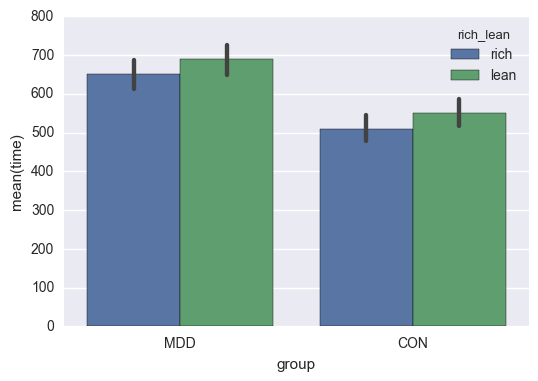

In [1122]:
rt_group_plot = sns.barplot(y='time', x = 'group', hue = 'rich_lean', data = data, ci = 68, units = 'subject')
%Rpush data
%R rt_anova <- aov_ez("subject", dv = "time", data = data,within = c("block","rich_lean"), between="group",anova_table=list(correction="none", es = "none"))
%R print (rt_anova)

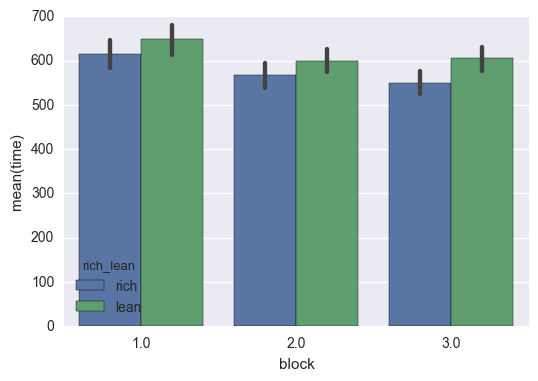

In [1123]:
rt_plot = sns.barplot(y='time', x = 'block', hue = 'rich_lean', data = data, ci = 68, units = 'subject')

In [1124]:
data.groupby('group').time.mean()

group
CON    530.448869
MDD    671.097993
Name: time, dtype: float64

In [1125]:
# these weren't read in as numbers
data.avT1_4 = data.avT1_4.apply(lambda x: float(x.replace(',','')))

Compare to 541.55 for controls and 676.48 reported in the paper. This is pretty different. I went back and added in their summary data for reaction time (avT1_4, so not from the trial data and using their rounding) and it looks almost identical to what we got for the trial stuff, so I don't really know where the other numbers are coming from. It's also frustrating because our F, p, and df are exactly the same, so we must be using the same data?

In [1126]:
data.groupby('group').avT1_4.mean()

group
CON    530.448871
MDD    671.097995
Name: avT1_4, dtype: float64

In [1127]:
data.groupby(['group','block', 'rich_lean']).time.mean() 

group  block  rich_lean
CON    1.0    lean         569.019656
              rich         533.740861
       2.0    lean         535.281427
              rich         503.235008
       3.0    lean         548.661777
              rich         493.366209
MDD    1.0    lean         734.173759
              rich         706.523214
       2.0    lean         670.199473
              rich         636.815697
       3.0    lean         668.909894
              rich         610.199288
Name: time, dtype: float64

### Hit rates

In [1128]:
# TODO!

## DDM

In [1129]:
ddm_data = data.rename(index = str, columns = {'subject' : 'subj_idx', 'correct': 'response', 'time': 'rt'})
ddm_data.to_csv('sigdep_ddm_data.csv')
ddm_data = hddm.load_csv('sigdep_ddm_data.csv')
ddm_data['rt'] = ddm_data['rt'] / 1000 # convert to seconds

In [1130]:
ddm_data.head()

,Unnamed: 0,subj_idx,date,bias,short_key,long_key,trial,length,rt,key_press,...,avlnT1_4,avshT1_4,avlgT1_4,excluded,Group#,Group,block,block_RB,block_disc,rich_lean
0,0,39,6/15/2004,short,/,z,1,short,0.499,/,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,rich
1,1,39,6/15/2004,short,/,z,2,long,0.628,z,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,lean
2,2,39,6/15/2004,short,/,z,3,short,0.705,/,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,rich
3,3,39,6/15/2004,short,/,z,4,long,0.588,z,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,lean
4,4,39,6/15/2004,short,/,z,5,short,0.667,z,...,734.02002,653.275146,734.02002,0,0,MDD,1.0,0.257556,0.577891,rich


In [1137]:
m_general = hddm.HDDM(ddm_data, depends_on={'v': 'group', 'a': 'group', 't':'group'})
m_general.find_starting_values()
m_general.sample(10000, burn=1000)

/Users/mlm2/anaconda/lib/python3.5/site-packages/pymc/Node.py:403: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.__name__ = input['__name__']


 [-----------------100%-----------------] 10000 of 10000 complete in 703.2 sec

/Users/mlm2/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


P_v(MDD > CON) =  0.0404444444444
P_v(CON > MDD) =  0.959555555556


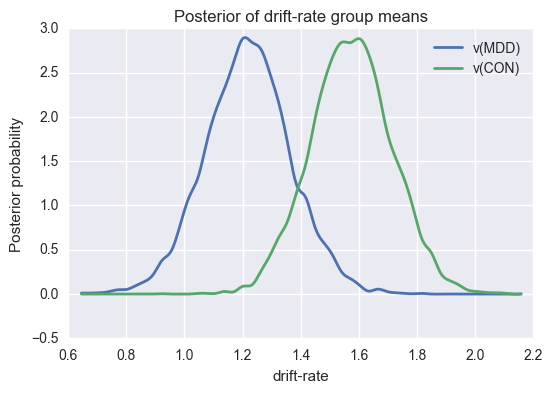

In [1138]:
v_MDD, v_CON = m_general.nodes_db.node[['v(MDD)','v(CON)']]
hddm.analyze.plot_posterior_nodes([v_MDD, v_CON])
plt.xlabel('drift-rate')
plt.ylabel('Posterior probability')
plt.title('Posterior of drift-rate group means')
plt.savefig('ctl_mdd_drift_rate_more_samples.pdf')

print ("P_v(MDD > CON) = ", (v_MDD.trace() > v_CON.trace()).mean())
print ("P_v(CON > MDD) = ", (v_CON.trace() > v_MDD.trace()).mean())

P_a(MDD > CON) =  0.998555555556
P_a(CON > MDD) =  0.00144444444444


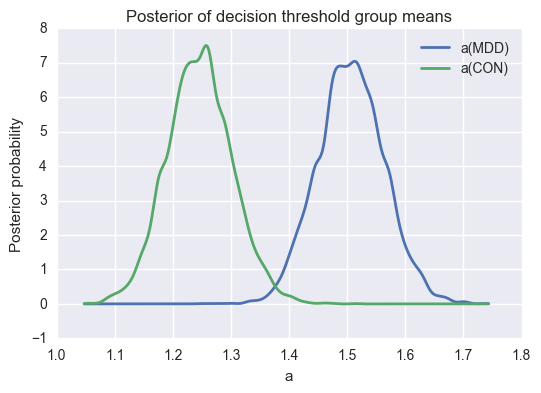

In [1139]:
a_MDD, a_CON = m_general.nodes_db.node[['a(MDD)','a(CON)']]
hddm.analyze.plot_posterior_nodes([a_MDD, a_CON])
plt.xlabel('a')
plt.ylabel('Posterior probability')
plt.title('Posterior of decision threshold group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_a(MDD > CON) = ", (a_MDD.trace() > a_CON.trace()).mean())
print ("P_a(CON > MDD) = ", (a_CON.trace() > a_MDD.trace()).mean())

P_t(MDD > CON) =  0.415222222222
P_t(CON > MDD) =  0.584777777778


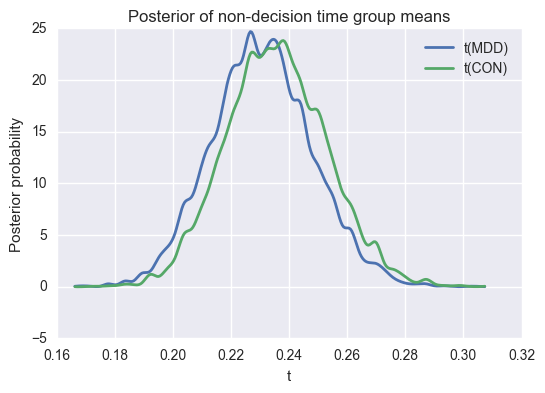

In [1140]:
t_MDD, t_CON = m_general.nodes_db.node[['t(MDD)','t(CON)']]
hddm.analyze.plot_posterior_nodes([t_MDD, t_CON])
plt.xlabel('t')
plt.ylabel('Posterior probability')
plt.title('Posterior of non-decision time group means')
plt.savefig('ctl_mdd_a_more_samples.pdf')

print ("P_t(MDD > CON) = ", (t_MDD.trace() > t_CON.trace()).mean())
print ("P_t(CON > MDD) = ", (t_CON.trace() > t_MDD.trace()).mean())

It's cool that at least so far we're seeing the same things as with the EMBARC data here. 